# Model COVID-19: Calibration

In [3]:
#=
## Necessary packages
using Pkg
Pkg.add("MAT")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("LinearAlgebra")
Pkg.add("SpecialFunctions")
Pkg.add("Interpolations")
Pkg.add("JLD")
Pkg.add("Random")
Pkg.add("ExcelReaders")
=#

## Call packages
using Plots
using MAT
using CSV
using DataFrames
using LinearAlgebra
using SpecialFunctions
using Interpolations
using JLD
using ExcelReaders
using Distributions
using Random


## Dynamic system

To predict the evolution of the number of deaths caused by the epidemic and highlight the importance of testing we extend a standard epidemiological age-structured SEIR (susceptible-exposed-infected-removed) model by (a) accounting for the age-specific mortality rates, (b) explicitly modeling the mortality rate of the COVID-19 epidemics and (c) introducing isolation periods during the incubation period ($E$) and the infectious period ($I$) after testing.  

To account for the differential effect of mortality by age, each state is comprised of 95 ($\Omega$) age-groups. We distinguish vectors and matrices from scalars by using bold letters. The dynamics of our extended age-structured SEIR model are as follows:

\begin{align}
{\dot{\bf S}_t} & = -{\beta}_t{\bf S}_t  - {\bf M}\cdot{\bf S}_t \\
{\dot{\bf E}^u_t}  & = {\beta}_t[1-\pi_E] {\bf S}_t - \sigma {\bf E}^u_t- {\bf M}\cdot{\bf E}^u_t\\
{\dot{\bf E}^d_t}  & =  {\beta}_t\pi_E {\bf S}_t - \sigma {\bf E}^d_t -{\bf M} \cdot{\bf E}^d_t \\
{\dot{\bf I}^u_t}  & =  \sigma [1-\pi_I] {\bf E}^u_t - \nu {\bf I}^u_t-{\bf M}  \cdot{\bf I}^u_t \\
{\dot{\bf I}^d_t}  & =  \sigma  \pi_I {\bf E}^u_t+\sigma{\bf E}^d_t  - \nu {\bf I}^d_t - {\bf M} \cdot {\bf I}^d_t \\
{\dot{\bf R}_t}  & =  \nu [\mathbf{1}-{\bf M}^{c}(\varepsilon)]{\bf I}^u_t +  \nu [\mathbf{1}-{\bf M}^{c}(\varepsilon)]{\bf I}^d_t - {\bf M} \cdot{\bf R}_t \\
{\dot{\bf D}^c_t}  & =  \nu {\bf M}^{c}(\varepsilon)\cdot ({\bf I}^u_t+{\bf I}^d_t)
\end{align}

where ${\beta}_t=\beta [{\sum_{x=0}^{\Omega}{\bf I}^u_t(x)}/{\sum_{x=0}^{\Omega}({\bf S}_t(x)+{\bf E}^u_t(x)+{\bf I}^u_t(x)+{\bf R}_t(x))}]$ is the infection rate and \(\beta\) is the effective transmission rate. ${\bf S}_t$ denotes the vector of susceptible individuals. $\{{\bf E}_t^u,{\bf I}_t^u\}$ denote the vector of exposed and infectious individuals, respectively, who are undetected. $\{{\bf E}^d_t, {\bf I}^d_t\}$ denote the vector of exposed and infectious individuals, respectively, who are detected (tested) and isolated. Note that we denote the state ${\bf I}^d_t$ as the infectious detected people and ${\bf E}^d_t$ as the detected exposed people (those having been in close contact with infected people and therefore been isolated). ${\bf R}_t$ is the vector of recovered individuals and ${\bf D}^{c}_t$ is the vector of deaths from the COVID-19 outbreak. $\mathbf{M}$ and $\mathbf{M}^{c}(\varepsilon)$ are, respectively, diagonal matrices with age-specific death rates not caused by COVID-19 and the estimated age-specific fatality rates for the COVID-19. The term $\varepsilon$ in $\mathbf{M}^{c}(\varepsilon)$ denotes the share of infectious and symptomatic individuals among all the infectious individuals (i.e. also including the asymptomatic cases). We assume that the (true) fatality rate, $\mathbf{M}^{c}(\varepsilon)$, is a fraction $\varepsilon$ of the (observed) case fatality rate. The (true) fatality rate is defined as the ratio between the total number of deaths from COVID-19 and the total number of infectious individuals, whereas the (observed) case fatality rate is the ratio between the total number of deaths from COVID-19 and the total infected individuals who are detected (tested). Thus, the lower the share of symptomatic individuals the lower the (true) fatality rate compared to the (observed) case fatality rate. ${\bf 1}$ denotes the identity matrix. The set of parameters $\{\beta,\pi_E,\pi_I, \nu,\sigma,\varepsilon\}$ denotes the effective transmission rate of the disease, the fraction of people isolated out of the exposed individuals, the fraction of people isolated out of the total infectious individuals, the removal rate, the inverse of the incubation period, and the share of infectious and symptomatic individuals. 


## Program

In [1]:
function fdS(S,QS,E,Ed,I,Id,R,D,Dcov,Id,M,Mcov,β,ρ,ν,σ,πS,πE,πI)
    
    βt=β*(sum(I)/sum(S+E+I+R))
    
    # Dynamic system
    dS   =-((βt+πS)*Id+M*dt)*S+ρ*QS
    dQS  =πS*Id*S-(ρ*Id+M*dt)*QS
    dE   =βt*(1.0-πE)*Id*S-((σ+πE)*Id+M*dt)*E
    dEd  =βt*πE*Id*S-(σ*Id+M*dt)*Ed    
    dI   =σ*(1.0-πI)*Id*E-(ν*Id+M*dt)*I
    dId  =σ*Id*Ed+σ*πI*Id*E-(ν*Id+M*dt)*Id    
    dR   =ν*(Id-Mcov)*I+ν*(Id-Mcov)*Id-dt*M*R
    dD   =M*(S+QS+E+Ed+I+Id+R)*dt
    dDcov=ν*Mcov*I+ν*Mcov*Id

    return dS, dQS, dE, dEd, dI, dId, dR, dD, dDcov, βt
    end;

In [2]:
function fDyn(β,ρ,ν,σ,πS,πE,πI,T,P,Id,M,Mc)
S  =zeros(MaxAge,T)
QS =zeros(MaxAge,T)    
E  =zeros(MaxAge,T)
Ed =zeros(MaxAge,T)
I  =zeros(MaxAge,T)
Id =zeros(MaxAge,T)
R  =zeros(MaxAge,T)
D  =zeros(MaxAge,T)
Dc =zeros(MaxAge,T)
dDc=zeros(MaxAge,T)
βV =zeros(1,T)

S[:,1]=P
I[1,1]=1.0

    for t=1:(T-1)
    S2, QS2, E2, Ed2, I2, Id2, R2, D2, Dc2, βV[1,t]=fdS(S[:,t],QS[:,t],E[:,t],Ed[:,t],I[:,t],Id[:,t],R[:,t],D[:,t],Dc[:,t],Id,M,Mc,β,ρ,ν,σ,πS,πE,πI);
    S[:,t+1] =S[:,t]+S2
    QS[:,t+1]=QS[:,t]+QS2                
    E[:,t+1] =E[:,t]+E2    
    Ed[:,t+1]=Ed[:,t]+Ed2        
    I[:,t+1] =I[:,t]+I2
    Id[:,t+1]=Id[:,t]+Id2
    R[:,t+1] =R[:,t]+R2    
    D[:,t+1] =D[:,t]+D2    
    Dc[:,t+1]=Dc[:,t]+Dc2          
    dDc[:,t] =Dc2          
    end
   return S, QS, E, Ed, I, Id, R, D, Dc, βV, dDc 
end;

In [5]:

data = readxl("PopData.xlsx", "Data!A1:E102")
data = DataFrame(data[2:end,:], [:Age, :PxAT, :mxAT, :PxCH, :mxCH]);

***Underlying fatality rates***

\begin{gather}
\log m_x=\beta_0+\beta_1 x+\beta_2 x^2+\epsilon
\end{gather}
which gives the following result in R

Coefficients:

|Coef       |Estimate |Std Error|$t$ value|$Pr(>|t|)$   |
| :---  | ---: | ---: | ---: | ---: |
|       |       |      |      |      |
|(Intercept)   |$-10.51$   | 0.9540   | $-11.013$ |  0.0016 $**$|
|age           |$ 0.1310$  | 0.03361  | $ 3.898$  |  0.0300 $*$ |
|age2          |$-0.003411$| 0.0002780|  $-1.227$ |  0.3073     |


Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1699 on 3 degrees of freedom
Multiple R-squared:  0.994,	Adjusted R-squared:  0.9899 
F-statistic: 246.8 on 2 and 3 DF,  p-value: 0.0004696


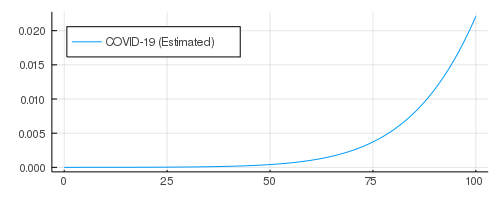

In [6]:
age=data[:,1]
mx=Array{Float64,1}(exp.(-10.5063.+0.1310116.*age.-0.0003411423.*(age.^2.0)))

plot(layout=1,size=(500,200),format="png",legend=:topleft)
plot!(age,0.05*(mx),label="COVID-19 (Estimated)",subplot=1)

In [7]:
Px    =Array{Float64,1}(data[:,4])
Px    =Px*(59020000/sum(Px)) # Adjustment to the population size of the population in the province in Hubei
Mx    =Diagonal(Array{Float64,1}(data[:,5]))
MxCOV =Diagonal(Array{Float64,1}(mx))
MaxAge=length(Px)
Ix    =Matrix{Float64}(I, MaxAge, MaxAge)
Ox    =zeros(Float64, MaxAge, MaxAge);

In [8]:
# Death toll
Cases = readxl("PopData.xlsx", "COVID_CHINA!A1:F89")
Cases = DataFrame(Cases[2:end,:], [:Date, :Days, :NewCases, :NewDeaths, :CumCases, :CumDeaths]);

In [10]:
const dt=1/365;

In [11]:
const samplesize=250000

for number=1:samplesize
    display(number)
βD =rand(Uniform(1.0/5.0,1.00),1,1)[1]   # Infectioness
νD =rand(Uniform(1.0/30,1.0/5.0),1,1)[1] # removal rate
σD =rand(Uniform(1.0/15.0,1.0),1,1)[1]   # incubation rate (incubation period 1-24 days)
πSD=0.0 # quarantine rate
πED=0.0 # testing rate among the exposed
πID=0.0 # testing rate among the infectious
ρD=0.0  # inverse of the average lockdown time
ϵ  =rand(Uniform(0.01,1.0),1,1)[1]

T  =88 # Total number of days
    
St, QSt, Et, Edt, It, Idt, Rt, Dt, Dct, βtV, dDct =fDyn(βD,ρD,νD,σD,πSD,πED,πID,T,Px,Ix,Mx,ϵ*MxCOV)
    
ErrE =(sum(Dct,dims=1)'-Cases[:,6])'
    
Calibration=[ErrE βD νD σD ϵ]    
#Uncomment to store the information    
#CSV.write("Calibration.csv",DataFrame(Calibration),delim=',';append=true);
end;
